In [ ]:
!pip install opendatasets --upgrade

In [ ]:
import opendatasets as od
url = 'https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign/data'
od.download(url)

Skipping, found downloaded files in "./skin-cancer-malignant-vs-benign" (use force=True to force download)


In [ ]:
import numpy as np
import os
import cv2 as cv2
import matplotlib.pyplot as plt

In [ ]:
path_train = '/content/skin-cancer-malignant-vs-benign/train'
path_test = '/content/skin-cancer-malignant-vs-benign/test'

In [ ]:
class_names = ['benign', 'malignant']
class_labels = {}
for i, classes in enumerate(class_names, start=0):
  class_labels[classes] = i

In [ ]:
image_size = (224, 224)

In [ ]:
#For Training data
train_data = []
train_labels = []

for folder in os.listdir(path_train):
    print("In folder: {}".format(folder))
    for file in os.listdir(os.path.join(path_train, folder)):
        image_path = os.path.join(path_train, folder, file)
        image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, image_size)  # Resize the image using image_size
        train_data.append(image)
        train_labels.append(class_labels[folder])

train_data = np.array(train_data, dtype='float32')
train_labels = np.array(train_labels, dtype='int32')

train_data = train_data / 255.0

In folder: malignant
In folder: benign


In [ ]:
#For Test data

test_data = []
test_labels = []

for folder in os.listdir(path_test):
  print("In folder: {}".format(folder))
  for file in os.listdir(os.path.join(path_test, folder)):
    image_path = os.path.join(path_test, folder, file)
    image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, image_size)
    test_data.append(image)
    test_labels.append(class_labels[folder])

test_data = np.array(test_data, dtype='float32')
test_labels = np.array(test_labels, dtype='int32')

test_data = test_data/255.0



In folder: malignant
In folder: benign


In [ ]:
data = np.concatenate((train_data, test_data), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

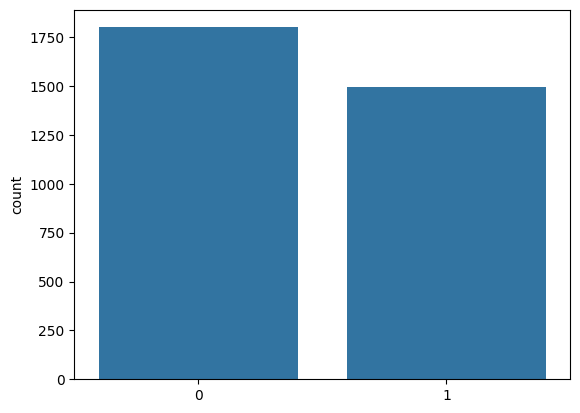

In [ ]:
sns.countplot(x=labels)
plt.show()

In [ ]:
print("\nImages in training set: {}".format(len(train_data)))
print("The type of training set is: {}".format(type(train_data)))
print("The shape of training set is: {}\n".format(train_data.shape))
train_counts = np.unique(train_labels, return_counts=True)
for i in train_counts[0]:
  print("Number of {} in training set is: {}".format(class_names[i], train_counts[1][i]))


print("\nImages in test set: {}".format(len(test_data)))
print("The type of test set is: {}".format(type(test_data)))
print("The shape of test set is: {}\n".format(test_data.shape))
test_counts = np.unique(test_labels, return_counts=True)
for i in test_counts[0]:
  print("Number of {} in test set is: {}".format(class_names[i], test_counts[1][i]))


Images in training set: 2637
The type of training set is: <class 'numpy.ndarray'>
The shape of training set is: (2637, 224, 224, 3)

Number of benign in training set is: 1440
Number of malignant in training set is: 1197

Images in test set: 660
The type of test set is: <class 'numpy.ndarray'>
The shape of test set is: (660, 224, 224, 3)

Number of benign in test set is: 360
Number of malignant in test set is: 300


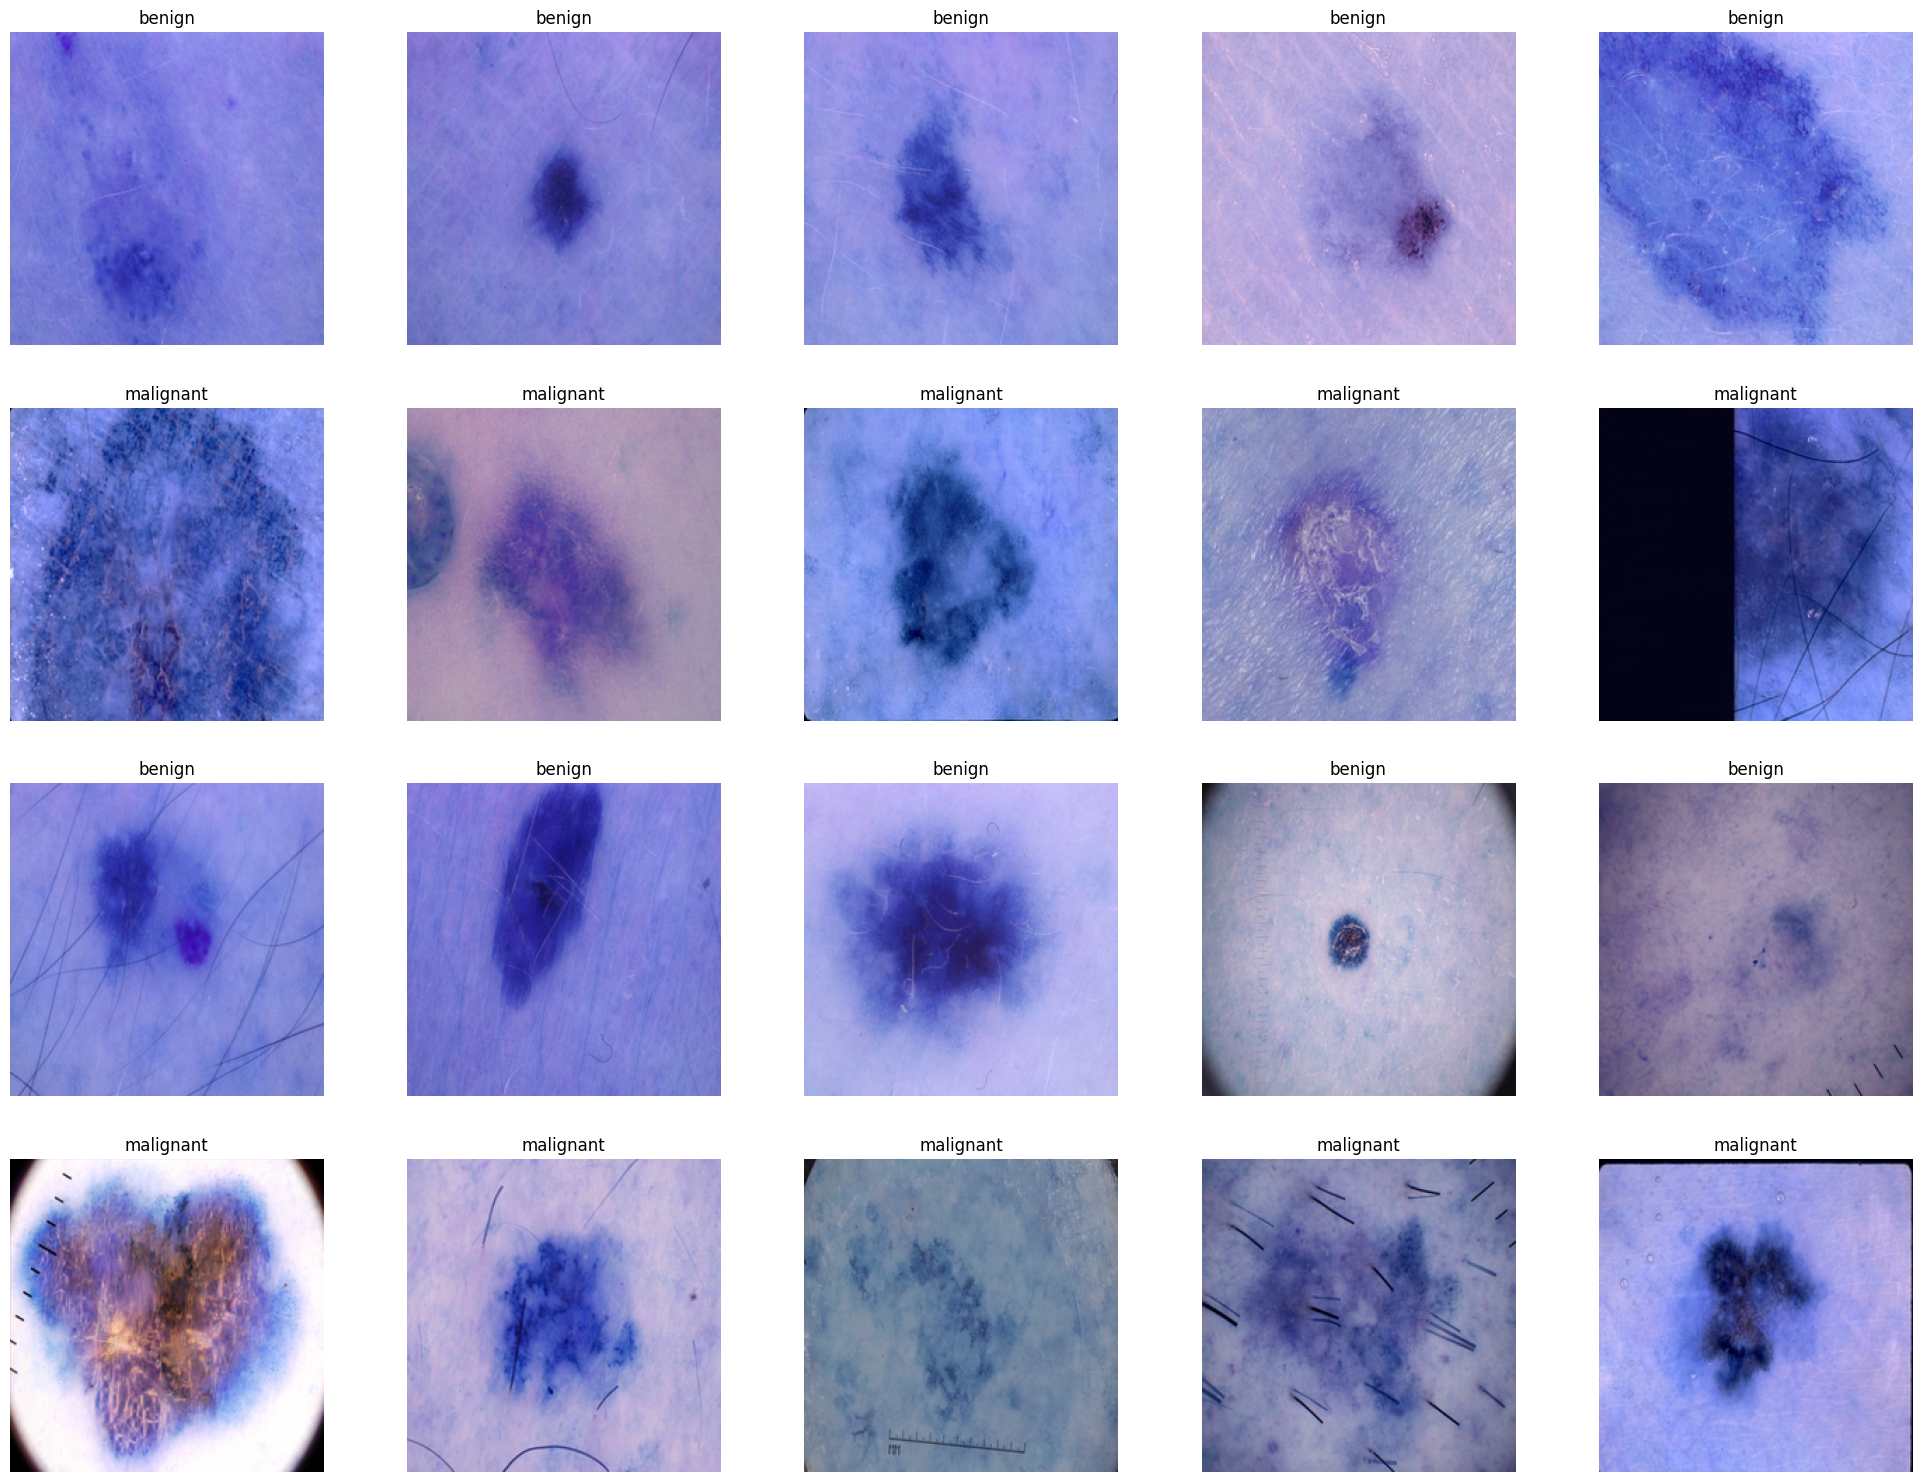

In [ ]:
import random
r_b = random.sample(list(np.where(train_labels == 0)[0]), 5)
r_f = random.sample(list(np.where(train_labels == 1)[0]), 5)
r_g = random.sample(list(np.where(train_labels == 0)[0]), 5)
r_m = random.sample(list(np.where(train_labels == 1)[0]), 5)

plots = np.array(r_b + r_f + r_g + r_m)
plots = plots.reshape(4, 5)

f, ax = plt.subplots(4, 5)
f.subplots_adjust(0, 0, 3, 3)

for i in range(4):
    for j in range(5):
        ax[i, j].imshow(train_data[plots[i, j]], cmap=plt.cm.gray)
        ax[i, j].set_title(class_names[train_labels[plots[i, j]]])
        ax[i, j].axis('off')

plt.show()


## Efficient-Net B0

In [ ]:
!pip install efficientnet

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Load the pre-trained EfficientNetB0 model + higher level layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add our custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compile the model
LEARNING_RATE = 1e-3
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define the callbacks
PATIENTCE = 5
MIN_DELTA = 0.01

early_stopping = EarlyStopping(monitor='val_accuracy', patience=PATIENTCE, restore_best_weights=True, min_delta=MIN_DELTA, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=1e-5, verbose=1)


In [ ]:
# Train the model
EPOCHS = 50
BATCH_SIZE = 32

history = model.fit(
    train_data,train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(test_data,test_labels),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
83/83 [==============================] - 69s 348ms/step - loss: 0.3885 - accuracy: 0.8142 - val_loss: 1.6099 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 2/50
83/83 [==============================] - 22s 269ms/step - loss: 0.2621 - accuracy: 0.8821 - val_loss: 0.7599 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 3/50
83/83 [==============================] - 22s 268ms/step - loss: 0.2280 - accuracy: 0.8976 - val_loss: 1.7629 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 4/50
83/83 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 0.9097
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
83/83 [==============================] - 22s 269ms/step - loss: 0.2075 - accuracy: 0.9097 - val_loss: 1.6256 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 5/50
83/83 [==============================] - 22s 270ms/step - loss: 0.1120 - accuracy: 0.9609 - val_loss: 0.6988 - val_accuracy: 0.5652 - lr: 1.0000e-04
Epoch 6/50
83/83 [==============================] - 22s 

In [ ]:
# After training is done, you can print or plot the training/validation losses and accuracies
losses_train = history.history['loss']
losses_val = history.history['val_loss']
accuracies_train = history.history['accuracy']
accuracies_val = history.history['val_accuracy']

# Print final results
print(f"Final training loss: {losses_train[-1]:.3f}")
print(f"Final validation loss: {losses_val[-1]:.3f}")
print(f"Final training accuracy: {accuracies_train[-1]:.2%}")
print(f"Final validation accuracy: {accuracies_val[-1]:.2%}")


Final training loss: 0.010
Final validation loss: 0.506
Final training accuracy: 99.77%
Final validation accuracy: 85.30%


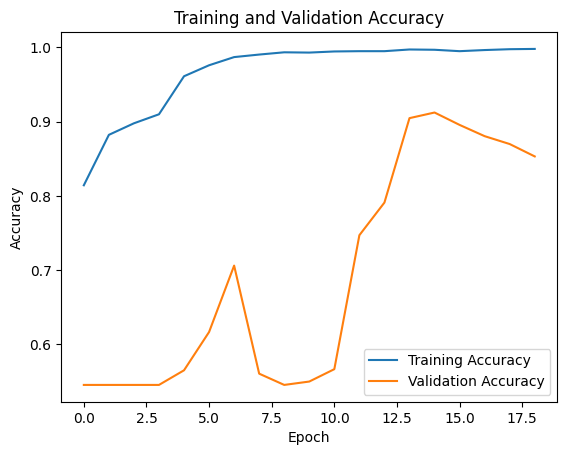

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Print the training accuracy
print("Training Accuracy:", history.history['accuracy'][-1])

Training Accuracy: 0.997724711894989


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_data, test_labels)
print("Testing Accuracy:", accuracy)

21/21 [==============================] - 1s 63ms/step - loss: 0.3952 - accuracy: 0.9045
Testing Accuracy: 0.9045454263687134


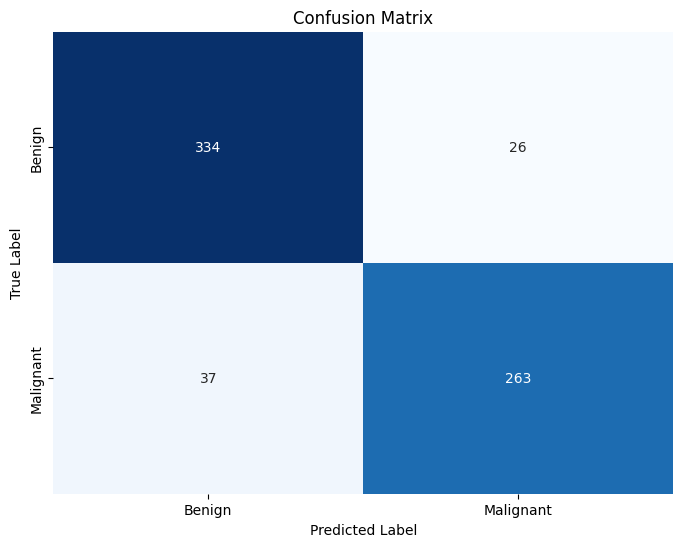

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert test labels from one-hot encoding to binary if necessary
if test_labels.ndim > 1 and test_labels.shape[1] > 1:
    test_labels_binary = np.argmax(test_labels, axis=1)
else:
    test_labels_binary = test_labels

# Ensure predicted labels are binary
threshold = 0.5
predicted_labels_binary = np.where(predictions > threshold, 1, 0)
if predicted_labels_binary.ndim > 1 and predicted_labels_binary.shape[1] > 1:
    predicted_labels_binary = np.argmax(predicted_labels_binary, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels_binary, predicted_labels_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Benign', 'Malignant'])
plt.yticks(ticks=[0.5, 1.5], labels=['Benign', 'Malignant'])
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Define the path
model_path = '/content/drive/My Drive/my_models/my_model.h5'

# Save the model
model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 1s/step


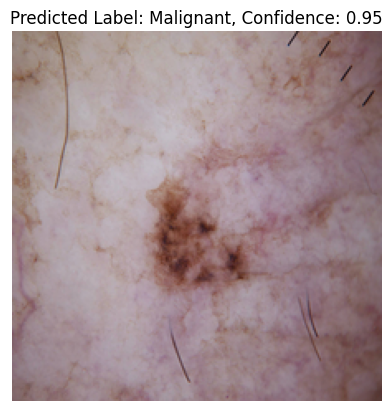

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model_path = '/content/drive/MyDrive/my_models/my_model.h5'
loaded_model = tf.keras.models.load_model(model_path)

# Load the image
image_path = '/content/skin-cancer-malignant-vs-benign/test/malignant/1027.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)  # Expand dimensions to create a batch with a single image
image_array = image_array / 255.0  # Normalize the image array

# Make predictions on the image
predictions = loaded_model.predict(image_array)

# Get the predicted label and confidence score
predicted_label = 'Malignant' if predictions[0][1] >= 0.5 else 'Benign'
confidence_score = predictions[0][1]  # Probability of the malignant class

# Plot the image with predicted label and confidence score
plt.imshow(image)
plt.title('Predicted Label: {}, Confidence: {:.2f}'.format(predicted_label, confidence_score))
plt.axis('off')
plt.show()


1/1 [==============================] - 2s 2s/step


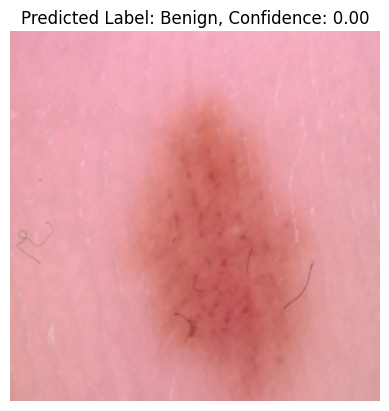

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model_path = '/content/drive/MyDrive/my_models/my_model.h5'
loaded_model = tf.keras.models.load_model(model_path)

# Load the image
image_path = '/content/skin-cancer-malignant-vs-benign/test/benign/1013.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)  # Expand dimensions to create a batch with a single image
image_array = image_array / 255.0  # Normalize the image array

# Make predictions on the image
predictions = loaded_model.predict(image_array)

# Get the predicted label and confidence score
predicted_label = 'Malignant' if predictions[0][1] >= 0.5 else 'Benign'
confidence_score = predictions[0][1]  # Probability of the malignant class

# Plot the image with predicted label and confidence score
plt.imshow(image)
plt.title('Predicted Label: {}, Confidence: {:.2f}'.format(predicted_label, confidence_score))
plt.axis('off')
plt.show()
